### Import lib

In [2]:
import os
os.chdir("/cerea_raid/users/dumontj/dev/coco2/dl")
import numpy as np
import sys
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
import matplotlib.pyplot as plt
import models.pw_reg as pwrg

### Loss functions

In [104]:
def my_mse(y_true,y_pred):
    return tf.reduce_mean(tf.square(y_pred-y_true)*(y_true+0.5))

### Data generation

In [105]:
# general param
N_img = 10_000
Ny = 32
Nx = 32
y, x = np.indices((Ny,Nx))

# data
magni = 3
center_Y = np.random.uniform(0,Ny, N_img).reshape(1,1,-1)
center_X = np.random.uniform(0,Nx, N_img).reshape(1,1,-1)
var_Y = np.random.uniform(0,20, N_img).reshape(1,1,-1)
var_X = np.random.uniform(0,20, N_img).reshape(1,1,-1)

data = magni * np.exp(-0.5*((np.expand_dims(x, axis=-1)-center_X)**2/var_X 
                            + (np.expand_dims(y, axis=-1)-center_Y)**2/var_Y))
data = np.where(data>0, data, 0)
# noise
noise = np.random.normal(0, 1, size=(N_img, Ny,Nx))


# datasets
data = np.transpose(data, (2,0,1))
data_X = (data + noise).reshape(N_img,Ny,Nx,1).astype(np.float32)
data_X = np.where(data_X>0, data_X, 0)

bin_data_Y = np.where(data.reshape(N_img,Ny,Nx,1)>0.1, 1., 0.).astype(np.float32)
reg_data_Y = np.where(data.reshape(N_img,Ny,Nx,1)>0.1, data.reshape(N_img,Ny,Nx,1), 0.).astype(np.float32)

data_Y = reg_data_Y 
#data_Y = bin_data_Y

ratio_train = 0.8
train_X = data_X[:int(ratio_train*N_img)]
train_Y = data_Y[:int(ratio_train*N_img)]
test_X = data_X[int(ratio_train*N_img):]
test_Y = data_Y[int(ratio_train*N_img):]


### Model def

In [106]:
model = pwrg.Unet_2(1, Ny, Nx, 1)
#model.compile("adam", loss=tf.keras.losses.MeanSquaredLogarithmicError())
model.compile("adam", loss=my_mse)

### Training

In [107]:
model.fit(x=train_X, y=train_Y, epochs=5, validation_data=(test_X, test_Y))

Epoch 1/5
250/250 [==============================] - 5s 18ms/step - loss: 0.0904 - val_loss: 0.0163
Epoch 2/5
250/250 [==============================] - 4s 17ms/step - loss: 0.0191 - val_loss: 0.0134
Epoch 3/5
250/250 [==============================] - 4s 16ms/step - loss: 0.0153 - val_loss: 0.0110
Epoch 4/5
250/250 [==============================] - 4s 16ms/step - loss: 0.0135 - val_loss: 0.0101
Epoch 5/5
250/250 [==============================] - 4s 17ms/step - loss: 0.0124 - val_loss: 0.0098


### Evaluation

error: tf.Tensor(0.0041648373, shape=(), dtype=float32)


Text(0.5, 1.0, 'image')

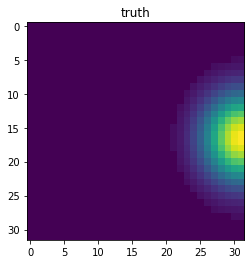

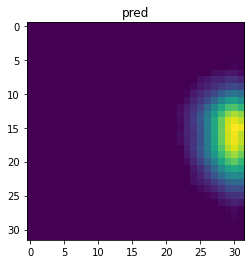

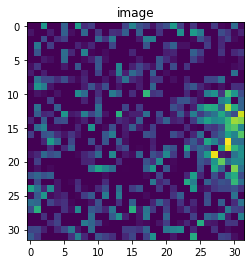

In [109]:
idx = int(np.random.uniform(0,N_img*0.2))
y_true = np.squeeze(test_Y[idx])
y_pred = np.squeeze(model(tf.expand_dims(test_X[idx], 0)))

# error
mse = tf.keras.losses.MeanSquaredError()
error = mse(y_true=y_true, y_pred=y_pred)
print("error:", error)

# plots
plt.figure()
plt.imshow(np.squeeze(test_Y[idx]))
plt.title("truth")
plt.figure()
plt.imshow(np.squeeze(model(tf.expand_dims(test_X[idx], 0))[0]))
plt.title("pred")
plt.figure()
plt.imshow(np.squeeze(test_X[idx]))
plt.title("image")